# Bramblemet water level example
The dataset consists of four weather stations in south England, each registering since April 2012 for every 5 minutes the following statistics:

 - DEPTH: water depth in metres

The four stations have the following locations:
![Bramblemet](https://www.bramblemet.co.uk/images/map.gif)

Replicate a similar experiment by Álvarez and Lawrence (https://papers.nips.cc/paper/3553-sparse-convolved-gaussian-processes-for-multi-output-regression), in which we train a multi-output Gaussian process on the Tidal Height data of the four sensors.

In [1]:
import numpy as np
import pandas as pd
import torch
import mogptk
import matplotlib.pyplot as plt
from utils import get_figsize, gen_1D_gp
from constants import columnwidth

torch.manual_seed(1);

We will load the four data series and combine their date and time fields. Additionally, we select a single week in June 2020.

In [2]:
start_date = '2020-06-01'
end_date = '2020-06-08'

print('Loading Bramble')
bramblemet = pd.read_csv('./bramblemet/bramblemet.csv.gz', compression='gzip', low_memory=False)
bramblemet['Date'] = pd.to_datetime(bramblemet['Date'] + ' ' + bramblemet['Time'], format='%d/%m/%Y %H:%M')
bramblemet = bramblemet.drop(columns=['Time'])
bramblemet = bramblemet.loc[(bramblemet['Date'] >= start_date) & (bramblemet['Date'] < end_date)]

print('Loading Camber')
cambermet = pd.read_csv('./bramblemet/cambermet.csv.gz', compression='gzip', low_memory=False)
cambermet['Date'] = pd.to_datetime(cambermet['Date'] + ' ' + cambermet['Time'], format='%d/%m/%Y %H:%M')
cambermet = cambermet.drop(columns=['Time'])
cambermet = cambermet.loc[(cambermet['Date'] >= start_date) & (cambermet['Date'] < end_date)]

print('Loading Chi')
chimet = pd.read_csv('./bramblemet/chimet.csv.gz', compression='gzip', low_memory=False)
chimet['Date'] = pd.to_datetime(chimet['Date'] + ' ' + chimet['Time'], format='%d/%m/%Y %H:%M')
chimet = chimet.drop(columns=['Time'])
chimet = chimet.loc[(chimet['Date'] >= start_date) & (chimet['Date'] < end_date)]

print('Loading Soton')
sotonmet = pd.read_csv('./bramblemet/sotonmet.csv.gz', compression='gzip', low_memory=False)
sotonmet['Date'] = pd.to_datetime(sotonmet['Date'] + ' ' + sotonmet['Time'], format='%d/%m/%Y %H:%M')
sotonmet = sotonmet.drop(columns=['Time'])
sotonmet = sotonmet.loc[(sotonmet['Date'] >= start_date) & (sotonmet['Date'] < end_date)]

bramblemet.head(5)

Loading Bramble
Loading Camber
Loading Chi
Loading Soton


,Date,WSPD,WD,GST,ATMP,WTMP,BARO,DEPTH,VIS
37972,2020-06-01 00:00:00,12.5,56,13.9,15.8,16.1,1021.9,1.91,27
37973,2020-06-01 00:05:00,11.5,56,13.0,15.7,16.3,1021.9,1.86,27
37974,2020-06-01 00:15:00,10.6,55,11.0,15.8,16.3,1021.8,1.80,27
37975,2020-06-01 00:20:00,9.5,47,10.3,15.7,16.4,1021.8,1.76,27
37976,2020-06-01 00:25:00,10.0,48,11.6,15.7,16.4,1021.7,1.75,27


We load the data series into MOGPTK and we detrend the data to improve trainability. We remove 90% of the data points at random so that training is quicker and required less memory. This has the added benefit that we can calculate the prediction error effectively for all the removed data points. In addition to removing data points at random, we also remove a few ranges in order to see how well data imputation for larger ranges works.

In [3]:
var_y_name = 'ATMP'

In [4]:
dataset = mogptk.DataSet(
    mogptk.LoadDataFrame(bramblemet, x_col='Date', y_col=[var_y_name], name='Bramble'),
    mogptk.LoadDataFrame(cambermet, x_col='Date', y_col=[var_y_name], name='Camber'),
    mogptk.LoadDataFrame(chimet, x_col='Date', y_col=[var_y_name], name='Chi'),
    mogptk.LoadDataFrame(sotonmet, x_col='Date', y_col=[var_y_name], name='Soton'),
)

for i, data in enumerate(dataset):
    data.transform(mogptk.TransformDetrend)
    data.remove_randomly(pct=0.9)

dataset['Bramble'].remove_range(start='2020-06-02', end='2020-06-03')
# dataset.set_prediction_data()
dataset['Camber'].remove_range(start='2020-06-06', end='2020-06-07')
dataset['Chi'].remove_range(start='2020-06-07', end='2020-06-08')
dataset['Soton'].remove_range(start='2020-06-04', end='2020-06-05')

In [5]:
sum([len(channel.get_test_data()[1]) for channel in dataset])

6850

In [6]:
sum([len(channel.get_train_data()[1]) for channel in dataset])

639

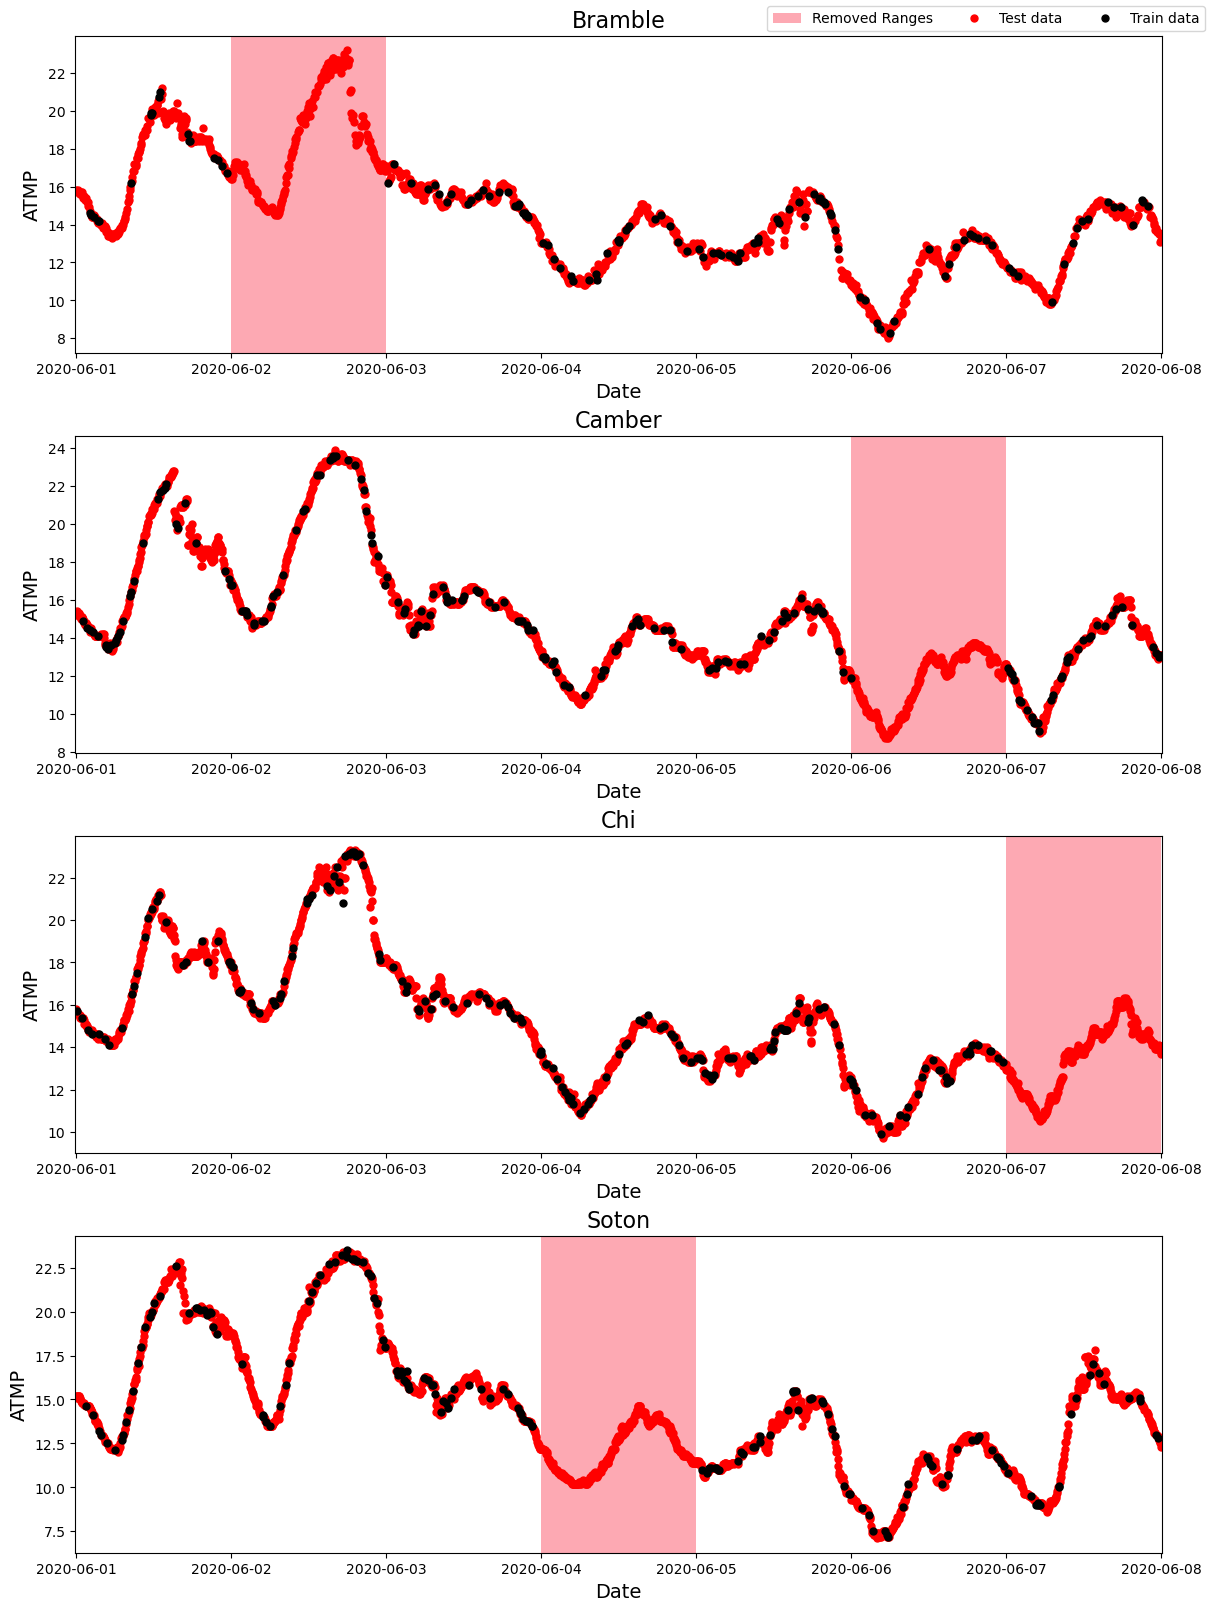

In [7]:
fig, _ = dataset.plot()
fig.savefig('../images/ukcoast_atmp.pdf',
    bbox_inches='tight',
    pad_inches = 0.1
    )

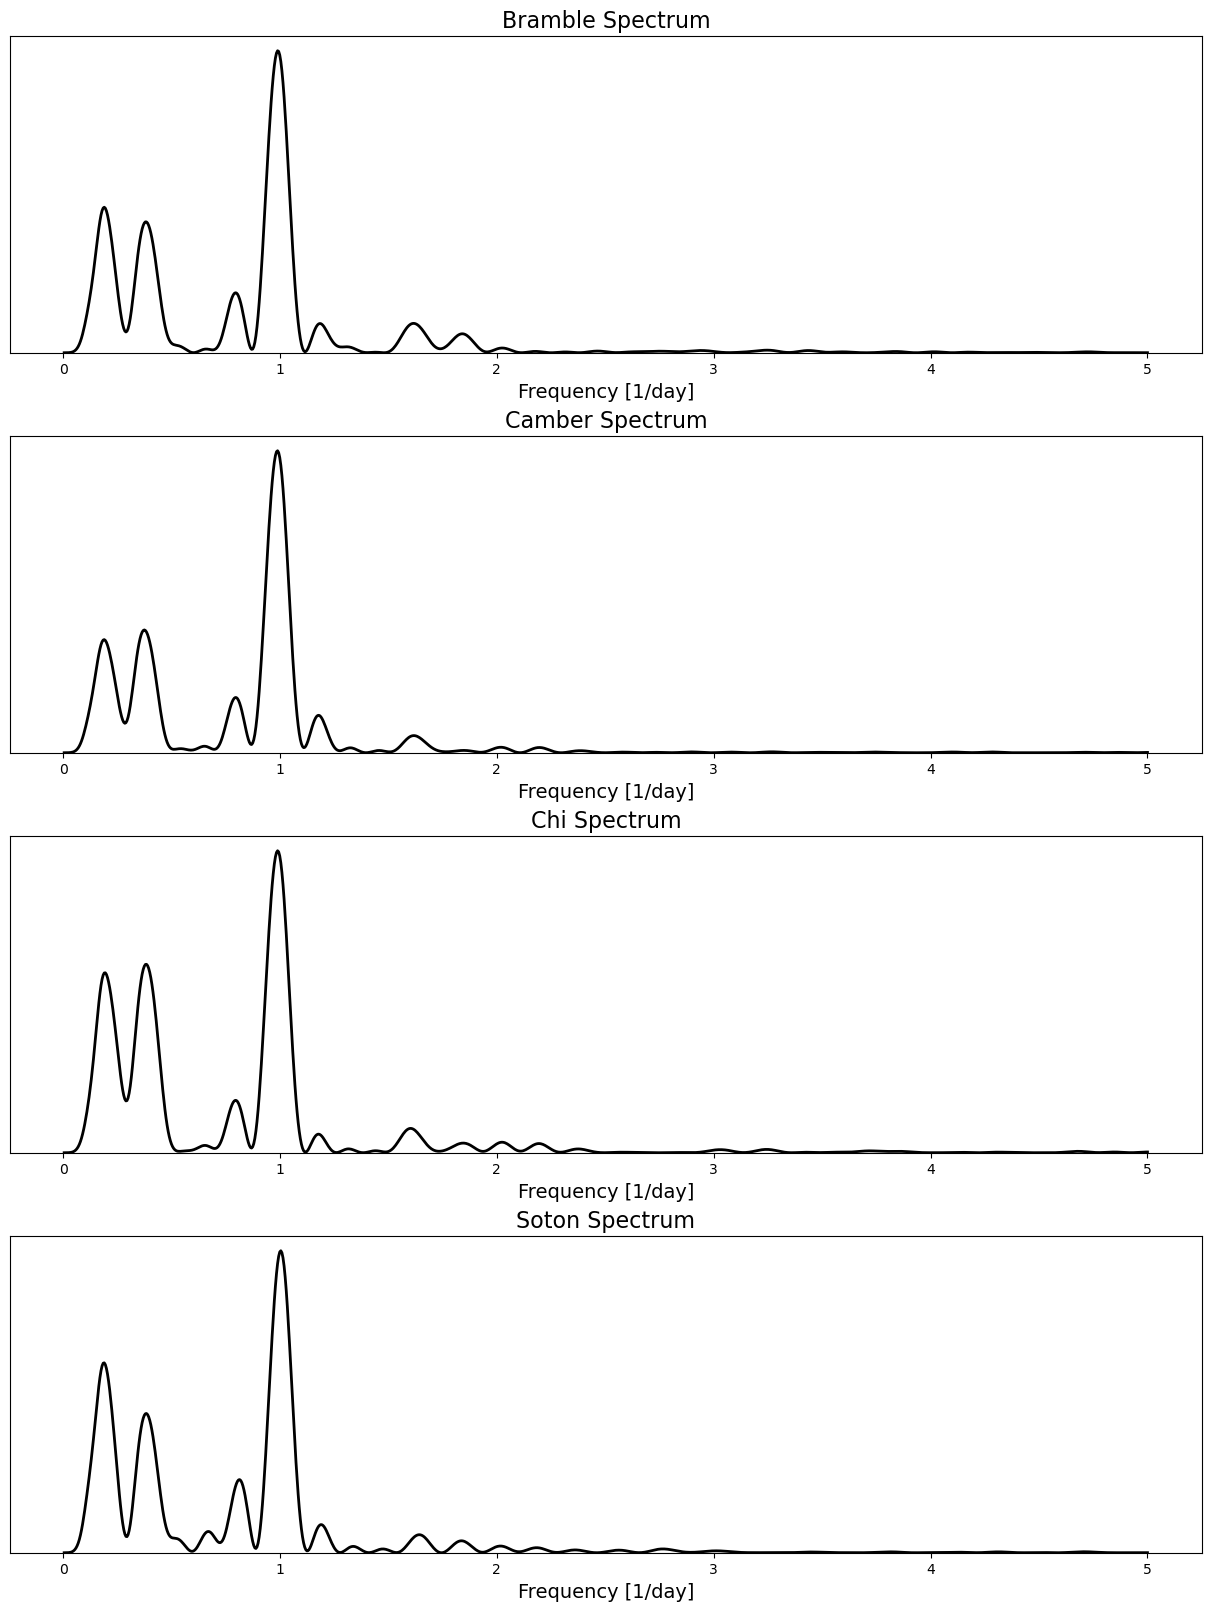

In [8]:
fig, ax = dataset.plot_spectrum(per='day', maxfreq=5, transformed=True);
fig.savefig('../images/ukcoast_atmp_spectrums.pdf',
    bbox_inches='tight',
    pad_inches = 0.1)

Cross-spectrum

In [9]:
dataset.get('Camber').get_nyquist_estimation()

array([0.1])

In [10]:
from scipy.signal import csd

f, csd_bramb_camb = csd(
    x=bramblemet.loc[:, var_y_name].to_numpy(),
    y=cambermet.loc[:, var_y_name].to_numpy(),
    fs=dataset.get('Camber').get_nyquist_estimation() * 2,
    detrend='linear',
    scaling='density'
)

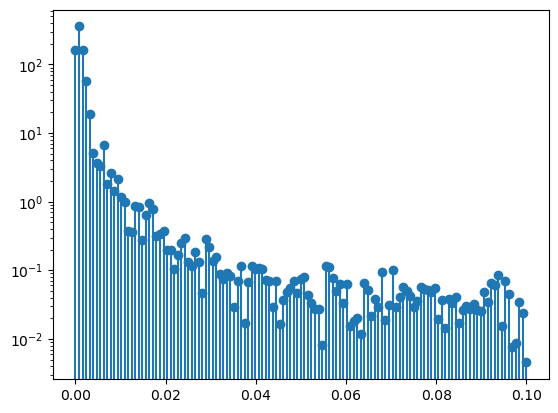

In [11]:
plt.stem(f, np.abs(csd_bramb_camb))
plt.yscale('log')

In the spectral information of our dataset we can observe that all channels have a periodicity of (almost) twice a day. This is true as we know that the ebb and flow tides have a period of about 12 hours and 25 minutes, so that we have slightly less than two full periods a day. $1.93$ times to be exact.

We will now train the MOSM, CSM, SM-LMC, and CONV kernels on this data set and compare their prediction errors. Training using the Adam optimizer with a relatively high learning rate has proven to give good results.

In [12]:
method = 'Adam'
lr = 0.02
iters = 1500

In [13]:
mosm = mogptk.MOSM(dataset, Q=4)
mosm.init_parameters(method='LS')
mosm.train(method=method, lr=lr, iters=iters, verbose=True)
mosm.print_parameters()

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 84
‣ Training points: 639
‣ Iterations: 1500
     0/1500   0:00:00  loss=     1270.77 (warmup)
   158/1500   0:00:10  loss=     1092.49
   331/1500   0:00:20  loss=     926.973
   498/1500   0:00:30  loss=     797.046
   660/1500   0:00:40  loss=      711.51
   821/1500   0:00:50  loss=      665.27
   975/1500   0:01:00  loss=     624.302
  1130/1500   0:01:10  loss=     581.727
  1287/1500   0:01:20  loss=     544.781
  1441/1500   0:01:30  loss=     532.416
  1500/1500   0:01:33  loss=     523.614
Optimization finished in 1 minute 33 seconds


Name,Range,Value
MultiOutputSpectralMixtureKernel.weight,"[1e-08, ∞)",[[39.25527988 29.18515154 30.32678962 1.50878074] [33.46677383 26.50283693 33.33041023 10.43417419] [27.13099671 27.63289565 31.85391387 15.74289647] [48.80307975 41.41769404 38.49309111 23.46182636]]
MultiOutputSpectralMixtureKernel.mean,"[1e-08, 0.1]",[[[8.98149668e-04] [9.16981667e-05] [2.71784768e-04] [3.35780107e-02]] [[7.10374851e-04] [1.17878765e-04] [2.49404559e-04] [1.28407021e-03]] [[6.57659442e-04] [1.06778702e-04] [2.55488784e-04] [1.08563692e-03]] [[8.14017180e-04] [1.05210840e-04] [2.74641837e-04] [5.84026441e-04]]]
MultiOutputSpectralMixtureKernel.variance,"[1e-08, ∞)",[[[1.26483158e-06] [6.18564333e-08] [3.07775354e-08] [2.50474011e-08]] [[4.43648726e-07] [6.49946415e-08] [3.09025206e-08] [1.58939127e-06]] [[1.71114465e-07] [7.24662941e-08] [3.31411373e-08] [2.80439174e-08]] [[6.21476159e-07] [4.25314692e-08] [2.78168467e-08] [4.11527769e-08]]]
MultiOutputSpectralMixtureKernel.delay,"(-∞, ∞)",[[[ 10.66635903] [ 1.39408381] [-18.31664445] [ 0. ]] [[-14.86487869] [ 21.18299783] [ 9.08188532] [ -5.99815202]] [[ 5.50470479] [ -1.7500536 ] [ 8.52200405] [ 7.33668586]] [[ 12.44349135] [-19.74581787] [ 4.29353272] [ 5.70410102]]]
MultiOutputSpectralMixtureKernel.phase,"(-∞, ∞)",[[-0.01904008 -0.01006388 -0.01078678 0. ] [ 0.02577316 0.00331951 0.02430164 0.05446584] [-0.01141798 -0.00234147 0.00378756 0.02696709] [-0.01212624 0.00771426 -0.01484722 -0.18527852]]
GaussianLikelihood.scale,"[1e-08, ∞)",[0.32744277 0.31430793 0.54797641 0.71685985]


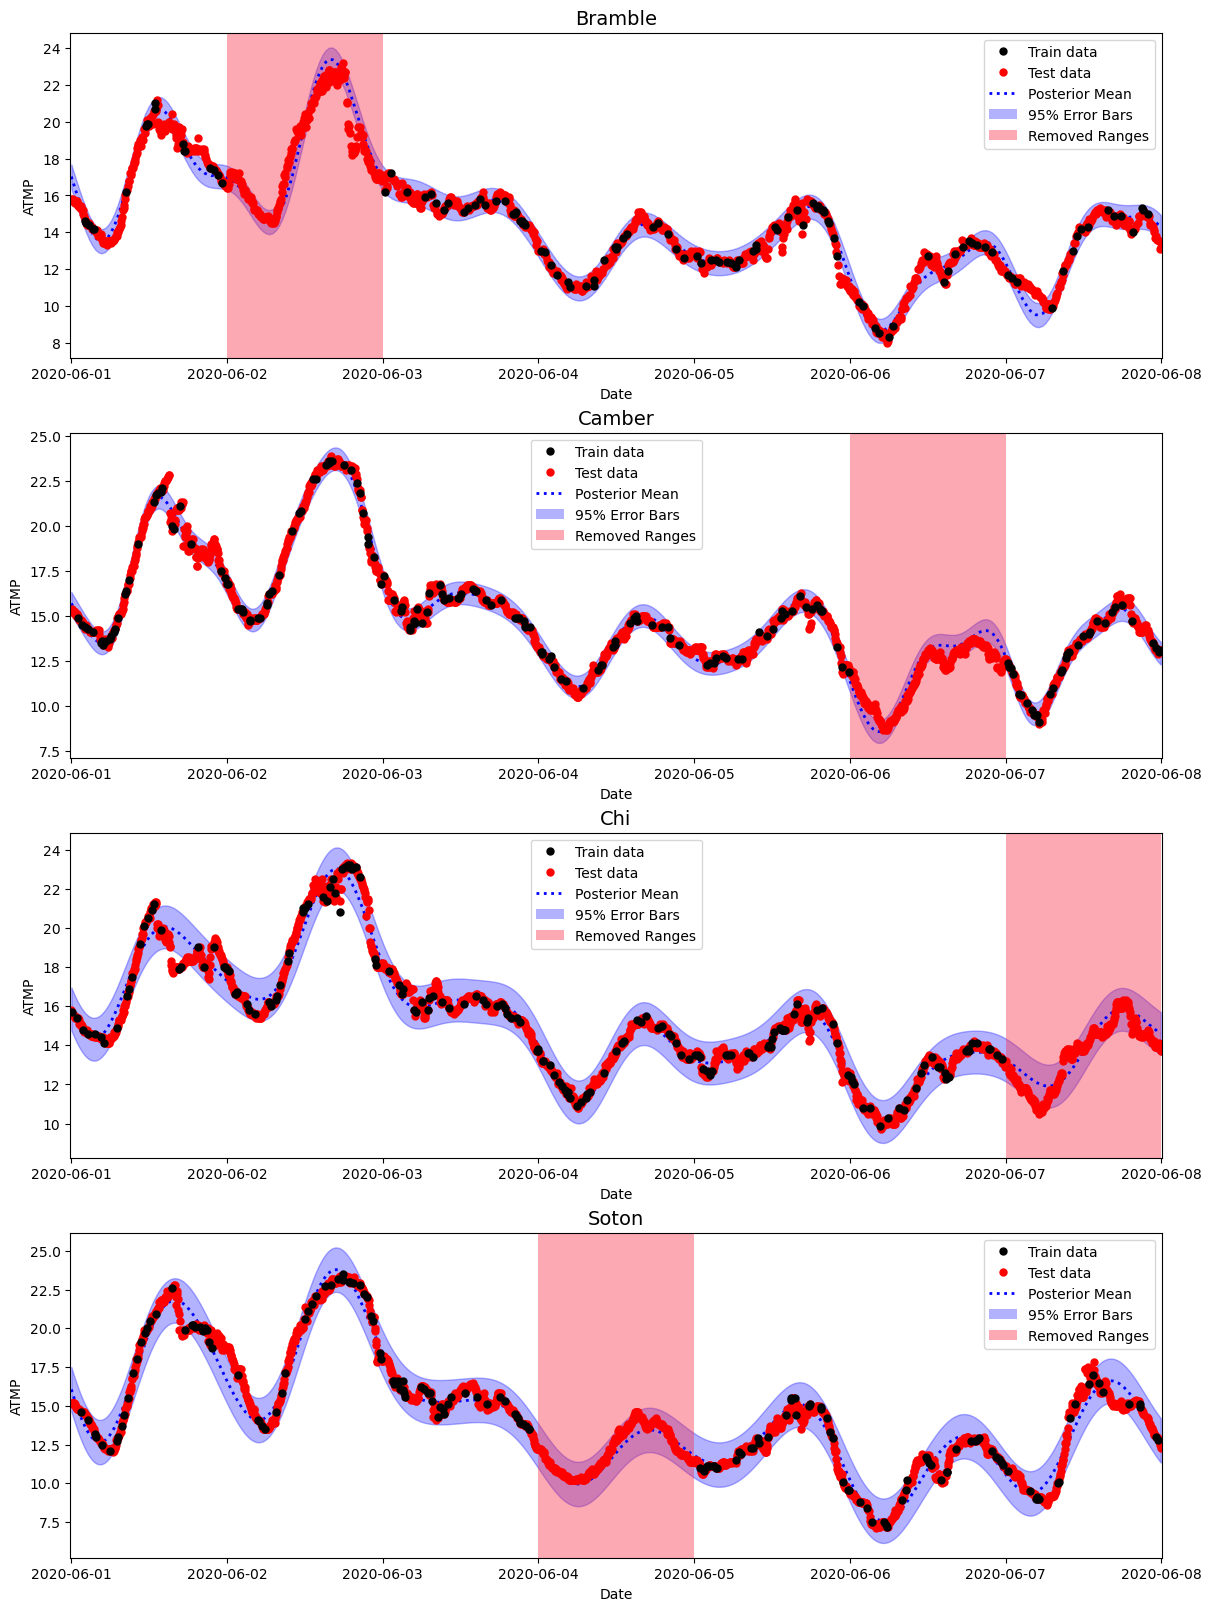

In [14]:
fig, axs = mosm.plot_prediction(transformed=False)

fig.savefig('../images/ukcoast_pred_mosm.pdf',
    bbox_inches='tight',
    pad_inches = 0.1
)

In [15]:
idx_bramb = 0
mean_bramb = mosm.predict(np.array(['2020-06-08 00:00:00']), sigma=1)[2][idx_bramb].tolist()
# get the standard deviation error and plot probability
sigma_bramb = mosm.gpr.likelihood.scale().tolist()[idx_bramb]

In [16]:
from scipy.stats import norm

post_bramble_0608 = norm(loc=mean_bramb, scale=sigma_bramb)
post_bramble_0608.cdf(14) - post_bramble_0608.cdf(13)

array([0.59982374])

In [17]:
mosm.predict(np.array(['2020-06-08 00:00:00']), ci=(0.05, 0.05))

([array([[26526240.]]),
  array([[26526240.]]),
  array([[26526240.]]),
  array([[26526240.]])],
 [array([14.24242999]),
  array([12.90666148]),
  array([14.57976788]),
  array([12.72685981])],
 [array([13.58754444]),
  array([12.27804561]),
  array([13.48381507]),
  array([11.29314011])],
 [array([14.89731553]),
  array([13.53527735]),
  array([15.6757207]),
  array([14.1605795])])

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_37695/2218974831.py:4: SyntaxWarning: invalid escape sequence '\p'
  axs.figure.axes[1].set_title('$k(t, t^\prime)$', fontsize='small')


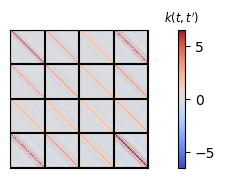

In [18]:
fig, axs = mosm.plot_gram(n = 50, figsize=get_figsize(columnwidth))

# name colorbar
axs.figure.axes[1].set_title('$k(t, t^\prime)$', fontsize='small')
fig.savefig('../images/ukcoast_crosskernel_mosm.pdf',
    bbox_inches='tight',
    pad_inches = 0.1
)

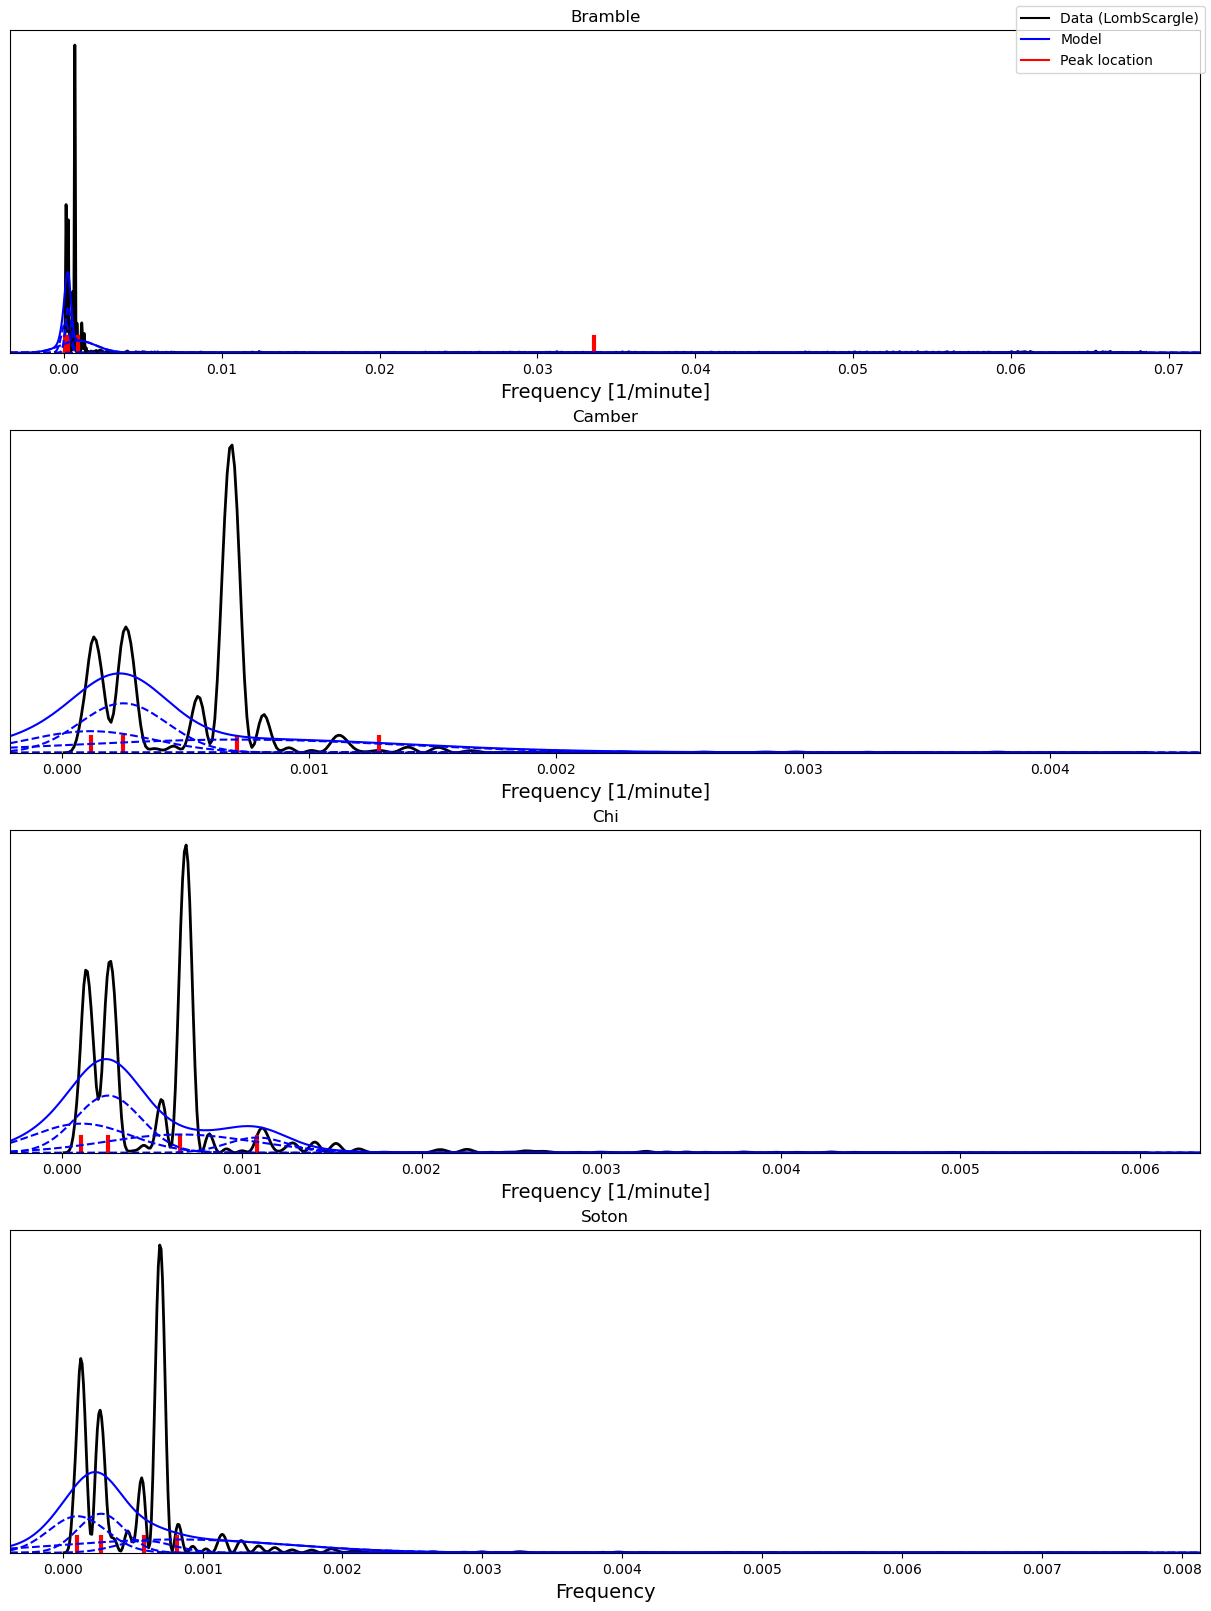

(<Figure size 1200x1600 with 4 Axes>,
 array([[<Axes: title={'center': 'Bramble'}, xlabel='Frequency [1/minute]'>],
        [<Axes: title={'center': 'Camber'}, xlabel='Frequency [1/minute]'>],
        [<Axes: title={'center': 'Chi'}, xlabel='Frequency [1/minute]'>],
        [<Axes: title={'center': 'Soton'}, xlabel='Frequency'>]],
       dtype=object))

In [19]:
mosm.plot_spectrum()

In [20]:
idsm = mogptk.SM(dataset=dataset, Q=4)
idsm.init_parameters(method='LS')
idsm.train(method=method, lr=lr, iters=iters, verbose=True)
idsm.print_parameters()

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: IndependentMultiOutputKernel[SpectralMixtureKernel,SpectralMixtureKernel,SpectralMixtureKernel,SpectralMixtureKernel]
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 52
‣ Training points: 639
‣ Iterations: 1500
     0/1500   0:00:00  loss=     1351.54 (warmup)
   228/1500   0:00:10  loss=     1116.91
   457/1500   0:00:20  loss=     916.496
   688/1500   0:00:30  loss=     742.583
   914/1500   0:00:40  loss=     606.936
  1125/1500   0:00:50  loss=     526.537
  1340/1500   0:01:00  loss=     480.056
  1500/1500   0:01:07  loss=     453.084
Optimization finished in 1 minute 7 seconds


Name,Range,Value
IndependentMultiOutputKernel[0].SpectralMixtureKernel.magnitude,"[1e-08, ∞)",[1.96486969 1.78204163 0.25818602 0.08877752]
IndependentMultiOutputKernel[0].SpectralMixtureKernel.mean,"[1e-08, 0.1]",[[0.00012196] [0.00060583] [0.00124336] [0.0493838 ]]
IndependentMultiOutputKernel[0].SpectralMixtureKernel.variance,"[1e-08, ∞)",[[6.74329529e-08] [1.41607867e-08] [1.99617371e-08] [2.06742680e-08]]
IndependentMultiOutputKernel[1].SpectralMixtureKernel.magnitude,"[1e-08, ∞)",[1.06997705 1.50185806 1.0156867 1.8924759 ]
IndependentMultiOutputKernel[1].SpectralMixtureKernel.mean,"[1e-08, 0.1]",[[3.32133441e-04] [6.47307420e-04] [6.48014524e-04] [2.79120755e-05]]
IndependentMultiOutputKernel[1].SpectralMixtureKernel.variance,"[1e-08, ∞)",[[6.58790492e-07] [1.38889243e-08] [1.36105562e-08] [3.22276099e-08]]
IndependentMultiOutputKernel[2].SpectralMixtureKernel.magnitude,"[1e-08, ∞)",[1.82943435 1.50582392 0.81799339 0.42480763]
IndependentMultiOutputKernel[2].SpectralMixtureKernel.mean,"[1e-08, 0.1]",[[0.00010376] [0.00061515] [0.00042954] [0.00017276]]
IndependentMultiOutputKernel[2].SpectralMixtureKernel.variance,"[1e-08, ∞)",[[4.68482803e-08] [1.49973208e-08] [1.26591092e-06] [5.08281639e-08]]
IndependentMultiOutputKernel[3].SpectralMixtureKernel.magnitude,"[1e-08, ∞)",[3.07236282 2.27713775 1.25670838 1.48238241]


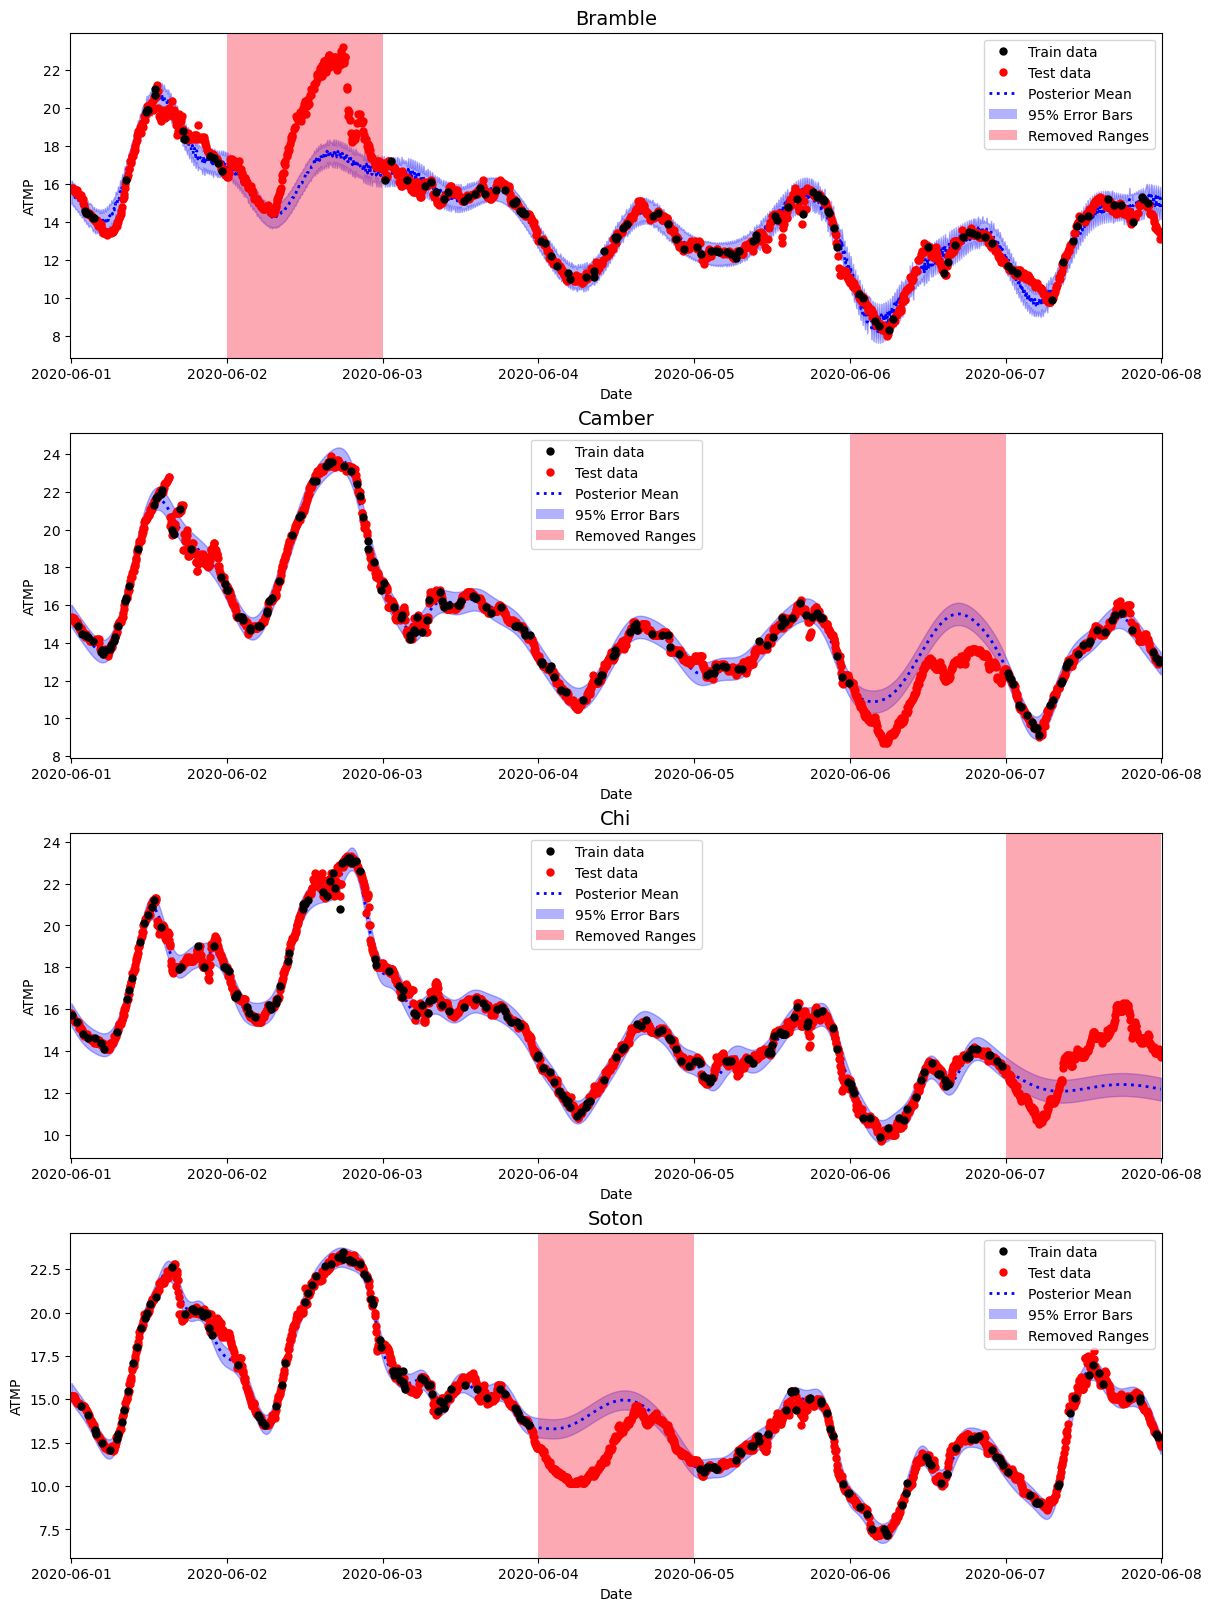

In [21]:
fig, axs = idsm.plot_prediction(transformed=False)

fig.savefig('../images/ukcoast_pred_idsm.pdf',
    bbox_inches='tight',
    pad_inches = 0.1
)

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_37695/3618088234.py:3: SyntaxWarning: invalid escape sequence '\p'
  axs.figure.axes[1].set_title('$k(t, t^\prime)$', fontsize='small')


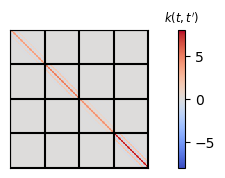

In [22]:
fig, axs = idsm.plot_gram(n = 50, figsize=get_figsize(columnwidth))

axs.figure.axes[1].set_title('$k(t, t^\prime)$', fontsize='small')
fig.savefig('../images/ukcoast_crosskernel_idsm.pdf',
    bbox_inches='tight',
    pad_inches = 0.1
)

Above we can see that the models fit the data fairly well. For a quantitative analysis, below we calculate the prediction error using the MAE, RMSE, and MAPE metrics. It can be observed that in this case the MOSM model fits better than independent (no inter-station correlation) to the data set, even though the test MAE is higher.

In [23]:
mogptk.error(mosm, per_channel=True, transformed=False, disp=True)

,MAE,MAPE,RMSE
Name,,,
MOSM channel 1,0.390593,2.675078,0.552984
MOSM channel 2,0.309670,2.214397,0.430926
MOSM channel 3,0.434883,2.836229,0.577550
MOSM channel 4,0.595269,4.284331,0.769739


In [24]:
# test only on specific ranges
for m in [mosm, idsm]:
    for d in m.dataset:
        d.reset()

    m.dataset['Bramble'].remove_range(start='2020-06-02', end='2020-06-03')
    m.dataset['Camber'].remove_range(start='2020-06-06', end='2020-06-07')
    m.dataset['Chi'].remove_range(start='2020-06-07', end='2020-06-08')
    m.dataset['Soton'].remove_range(start='2020-06-04', end='2020-06-05')

In [25]:
def print_error_as_latex(model):
    from pandas import DataFrame

    df = DataFrame(
        mogptk.error(model, per_channel=True, transformed=False, disp=False)[0],
        index=model.dataset.get_names()
    )
    print(df.to_latex(columns=['MAE', 'MAPE', 'RMSE'], float_format='{:.2f}'.format))

In [26]:
print('MO spectral mixture')
print_error_as_latex(mosm)

print('Independent spectral mixture')
print_error_as_latex(idsm)

MO spectral mixture
\begin{tabular}{lrrr}
\toprule
 & MAE & MAPE & RMSE \\
\midrule
Bramble & 0.65 & 3.44 & 0.89 \\
Camber & 0.61 & 5.27 & 0.72 \\
Chi & 0.61 & 4.72 & 0.71 \\
Soton & 0.45 & 3.55 & 0.54 \\
\bottomrule
\end{tabular}

Independent spectral mixture
\begin{tabular}{lrrr}
\toprule
 & MAE & MAPE & RMSE \\
\midrule
Bramble & 2.10 & 10.37 & 2.79 \\
Camber & 1.58 & 13.82 & 1.74 \\
Chi & 1.76 & 12.53 & 2.01 \\
Soton & 1.68 & 15.00 & 2.13 \\
\bottomrule
\end{tabular}

